# Измерение производительности JIT-компиляции

Будут сравниваться три подхода:
1. Питон без улучшений
2. С аннотацией `@jit`
3. С аннотацией `@numba.jit`

In [1]:
from annotation import jit
from timeit import timeit, repeat
import numba

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_jit_numba_realisations(func):
    """По входной функции возвращает две оптимизации"""
    jit_func = jit(func)
    numba_func = numba.jit(func, nopython=True)
    return jit_func, numba_func

## Замеры времени компиляции

In [3]:
def py_sum(x: int, y: int) -> int:
    res: int = x + y
    return res

In [4]:
jit_time = repeat(lambda: jit(py_sum), repeat=10, number=1)
jit_time

[0.12362709999433719,
 0.07699030000367202,
 0.07569739999598823,
 0.07125889998860657,
 0.07256569998571649,
 0.07348590000765398,
 0.06936300001689233,
 0.07112749997759238,
 0.07719340000767261,
 0.07802680000895634]

In [5]:
numba_jit_time = repeat(lambda: numba.jit(py_sum), repeat=10, number=1)
numba_jit_time

[0.02519010001560673,
 9.300000965595245e-05,
 5.950001650489867e-05,
 5.5500015150755644e-05,
 5.299999611452222e-05,
 5.299999611452222e-05,
 5.2499992307275534e-05,
 5.189998773857951e-05,
 5.1700015319511294e-05,
 5.190001684240997e-05]

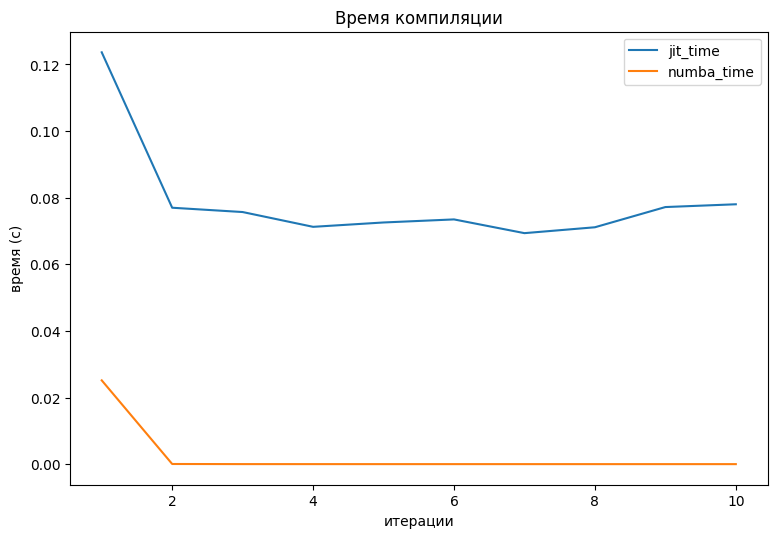

In [62]:
xs = range(1, 11)

plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(xs, jit_time, label='jit_time')
plt.plot(xs, numba_jit_time, label='numba_time')
plt.xlabel('итерации')
plt.ylabel('время (с)')
plt.title('Время компиляции')
plt.legend()
plt.savefig("report/plots/compile_sum.png")
plt.show()

Выводы:
* Компиляция в @numba.jit происходит быстрее в 5 раз
* @numba.jit не выполняет повторную компиляцию модуля, за счёт чего экономит время

## Замеры времени нескольких вызовов

In [90]:
jit_sum = jit(py_sum)
numba_sum = numba.jit(py_sum)


[1.00000761449337e-06, 3.00002284348011e-07, 2.00001522898674e-07, 1.00000761449337e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07]
[7.800001185387373e-06, 2.3999891709536314e-06, 7.00005330145359e-07, 6.00004568696022e-07, 6.00004568696022e-07, 2.0999868866056204e-06, 7.00005330145359e-07, 6.00004568696022e-07, 5.999754648655653e-07, 2.100015990436077e-06]
[0.026302100013708696, 1.6999838408082724e-06, 4.00003045797348e-07, 3.00002284348011e-07, 3.00002284348011e-07, 3.00002284348011e-07, 3.00002284348011e-07, 2.00001522898674e-07, 3.00002284348011e-07, 2.00001522898674e-07]


In [95]:
python_exec_time = repeat(lambda: py_sum(2, 2), repeat=10, number=1)
print(python_exec_time)
jit_exec_time = repeat(lambda: jit_sum(2, 2), repeat=10, number=1)
print(jit_exec_time)
numba_exec_time = repeat(lambda: numba_sum(2, 2), repeat=10, number=1)
print(numba_exec_time)

[2.1999876480549574e-06, 3.00002284348011e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 1.00000761449337e-07, 2.00001522898674e-07, 2.00001522898674e-07]
[8.299975888803601e-06, 9.00006853044033e-07, 7.999769877642393e-07, 2.400018274784088e-06, 2.500019036233425e-06, 2.2999884095042944e-06, 6.00004568696022e-07, 3.1999952625483274e-06, 5.999754648655653e-07, 7.00005330145359e-07]
[5.2000104915350676e-06, 4.00003045797348e-07, 2.999731805175543e-07, 3.00002284348011e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 3.00002284348011e-07, 2.00001522898674e-07, 2.00001522898674e-07]


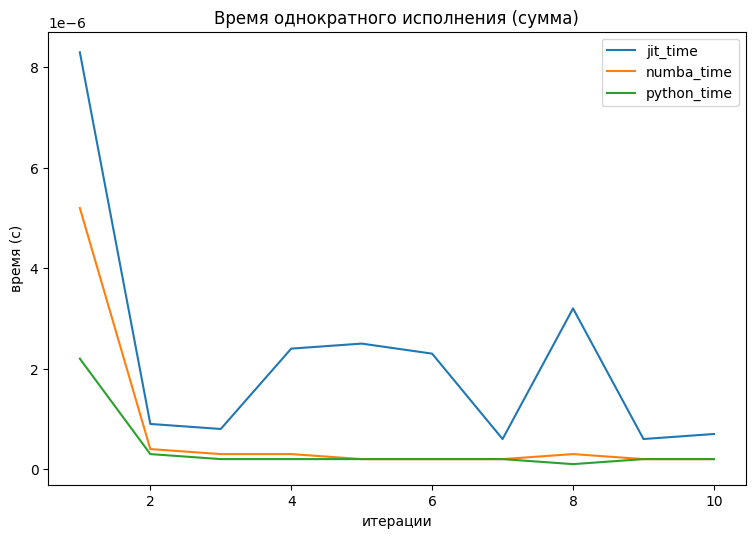

In [96]:
xs = range(1, 11)
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(xs, jit_exec_time, label='jit_time')
plt.plot(xs, numba_exec_time, label='numba_time')
plt.plot(xs, python_exec_time, label='python_time')
plt.xlabel('итерации')
plt.ylabel('время (с)')
plt.title('Время однократного исполнения (сумма)')
plt.legend()
plt.savefig("report/plots/exec_sum_once.png")
plt.show()

Выводы:
* У функции с аннотацией @numba.jit неприлично большое время первого запуска. Видимо, при первом запуске
выполняются некоторые этапы компиляции.

## Усреднённые значения вызовов на простой функции

In [97]:
python_exec_time = repeat(lambda: py_sum(2, 2), repeat=10, number=1000000)
print(python_exec_time)
print(np.var(python_exec_time))
jit_exec_time = repeat(lambda: jit_sum(2, 2), repeat=10, number=1000000)
print(jit_exec_time)
print(np.var(jit_exec_time))
numba_exec_time = repeat(lambda: numba_sum(2, 2), repeat=10, number=1000000)
print(numba_exec_time)
print(np.var(numba_exec_time))

[0.10241999998106621, 0.10005049998289905, 0.10050030000275001, 0.1603322000009939, 0.10191100000520237, 0.0989304999820888, 0.10015449998900294, 0.0997481000085827, 0.0995147000066936, 0.10045649998937733]
0.0003241576317861971
[0.44748799997614697, 0.4427152999851387, 0.44133050000527874, 0.4397840000165161, 0.4480012000130955, 0.5083969999977853, 0.4457891999918502, 0.443449700018391, 0.4431332999956794, 0.43978000001516193]
0.00038653441924498845
[0.15764550000312738, 0.157027500012191, 0.16046039998764172, 0.15531179998652078, 0.15603159999591298, 0.15626010001869872, 0.1595392000162974, 0.15662240001256578, 0.15794810000807047, 0.16022009999142028]
2.959129553340058e-06


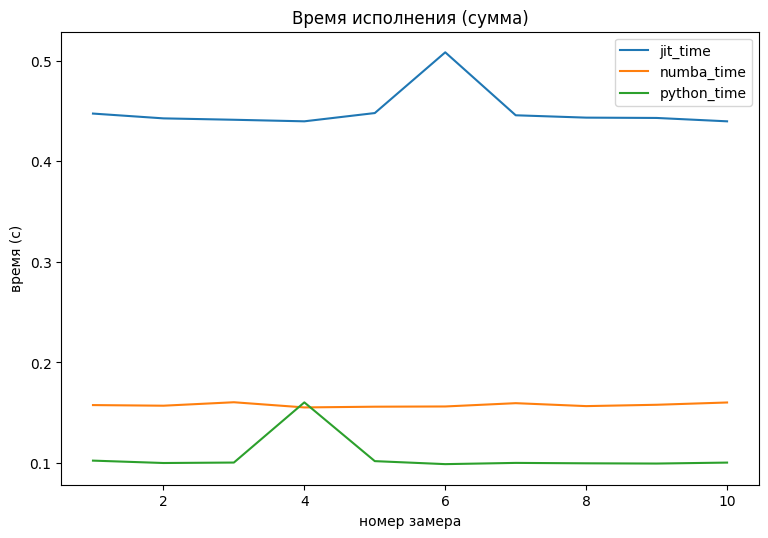

In [98]:
xs = range(1, 11)
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(xs, jit_exec_time, label='jit_time')
plt.plot(xs, numba_exec_time, label='numba_time')
plt.plot(xs, python_exec_time, label='python_time')
plt.xlabel('номер замера')
plt.ylabel('время (с)')
plt.title('Время исполнения (сумма)')
plt.legend()
plt.savefig("report/plots/exec_sum.png")
plt.show()

Выводы:
* На простых функциях питон без jit-компиляции выполняется быстрее, чем с ней.
* И всё-таки на простых функциях numba проигрывает Питону в 1,5 раза, а ручная jit аннотация в 4,5.

## Измерение скорости выполнения

### Функция вычисления экспоненты с помощью разложения в ряд Тейлора

In [36]:
def py_exp(x: float) -> float:
    res: float = 0
    threshold: float = 1e-30
    delta: float = 1
    elements: int = 0
    while delta > threshold:
        elements = elements + 1
        delta = delta * x / elements
    while elements >= 0:
        res += delta
        delta = delta * elements / x
        elements -= 1
    return res

jit_exp, numba_exp = get_jit_numba_realisations(py_exp)


In [66]:
arg = 250
print(f"exp({arg}) = {jit_exp(arg):.30f}")
args = range(10, 260, 10)
jit_exp_time, numba_exp_time, python_exp_time = [], [], []
for arg in args:
    jit_exp_time.append(timeit(lambda: jit_exp(arg), number=10000))
    numba_exp_time.append(timeit(lambda: numba_exp(arg), number=10000))
    python_exp_time.append(timeit(lambda: py_exp(arg), number=10000))
print(jit_exp_time)
print(numba_exp_time)
print(python_exp_time)

exp(250) = 3746454614502660877998657881484689260451454624001099543290316630153610787704025897267034669677141296546840576.000000000000000000000000000000
[0.009242599975550547, 0.011190899997018278, 0.013690699997823685, 0.020293099980335683, 0.017876700003398582, 0.02010550000704825, 0.022006699990015477, 0.024198300001444295, 0.026575099996989593, 0.028219399973750114, 0.029995999997481704, 0.032290899980580434, 0.03418330001295544, 0.036316600017016754, 0.03844780000508763, 0.04036790001555346, 0.042470999993383884, 0.04458620000514202, 0.046442899998510256, 0.049126300000352785, 0.050673199992161244, 0.05277040001237765, 0.05468050000490621, 0.056531200010795146, 0.06069000001298264]
[0.006709999986924231, 0.00934599997708574, 0.011705899989465252, 0.016744799999287352, 0.016271600004984066, 0.018529599998146296, 0.020033699984196573, 0.022446799994213507, 0.02443920000223443, 0.026265499996952713, 0.028258000005735084, 0.030334899987792596, 0.03229279999504797, 0.034486699994886294,

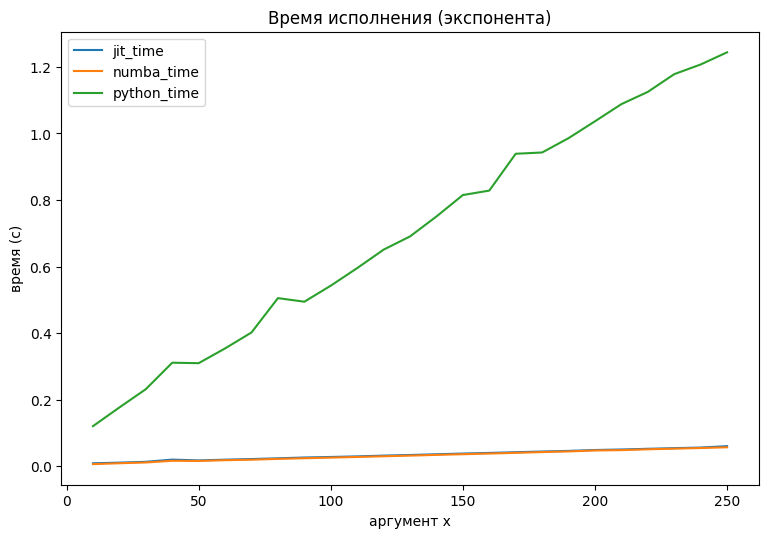

In [67]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_exp_time, label='jit_time')
plt.plot(args, numba_exp_time, label='numba_time')
plt.plot(args, python_exp_time, label='python_time')
plt.xlabel('аргумент x')
plt.ylabel('время (с)')
plt.title('Время исполнения (экспонента)')
plt.legend()
plt.savefig("report/plots/exec_exp_3.png")
plt.show()

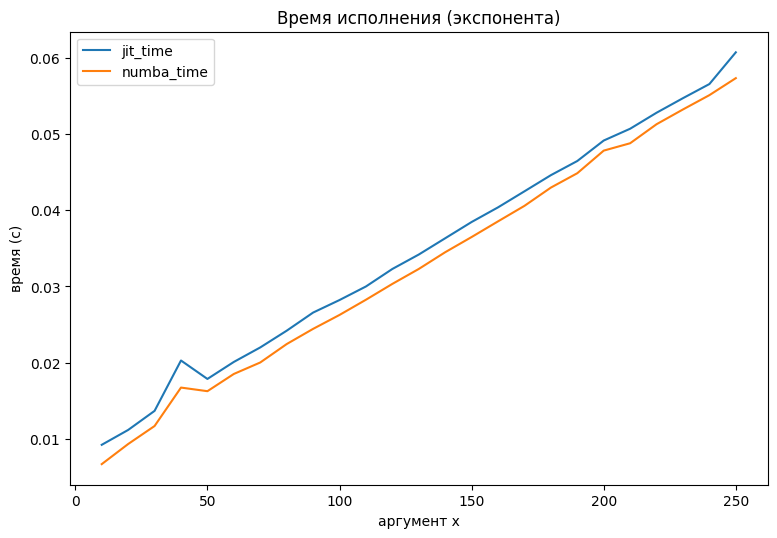

In [69]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_exp_time, label='jit_time')
plt.plot(args, numba_exp_time, label='numba_time')
plt.xlabel('аргумент x')
plt.ylabel('время (с)')
plt.title('Время исполнения (экспонента)')
plt.legend()
plt.savefig("report/plots/exec_exp_2.png")
plt.show()

Выводы:
* Аномалия первого запуска numba функции была обсуждена ранее
* На больших алгоритмических сложностях питон сдаёт позиции
* Отличие производительности двух методов оптимизации незначительно на больших значениях аргумента

### Простая хеш-функция для целых чисел

In [85]:
def py_hash(x: int) -> int:
    x = ((x >> 16) ^ x) * 0x45d9f3b
    x = ((x >> 16) ^ x) * 0x45d9f3b
    x = (x >> 16) ^ x
    return x


jit_hash, numba_hash = get_jit_numba_realisations(py_hash)

In [86]:
python_exec_time = repeat(lambda: py_hash(42), repeat=10, number=1000000)
print(python_exec_time)
jit_exec_time = repeat(lambda: jit_hash(42), repeat=10, number=1000000)
print(jit_exec_time)
numba_exec_time = repeat(lambda: numba_hash(42), repeat=10, number=1000000)
print(numba_exec_time)

[0.34607169998344034, 0.3991195999842603, 0.3448967000003904, 0.34391719999257475, 0.3425489999935962, 0.33988070001942106, 0.3351282000076026, 0.33668340000440367, 0.348129499994684, 0.3366838999791071]
[0.33954799998900853, 0.34020269999746233, 0.33473900001263246, 0.34276410000165924, 0.3840565999853425, 0.3397419999819249, 0.3411387999949511, 0.3384917000075802, 0.34082240000134334, 0.3431267999985721]
[0.19324700001743622, 0.16466020001098514, 0.15843170002335683, 0.15664549998473376, 0.15624829998705536, 0.1542726999905426, 0.15371530002448708, 0.15294209998683073, 0.15267929999390617, 0.15480550000211224]


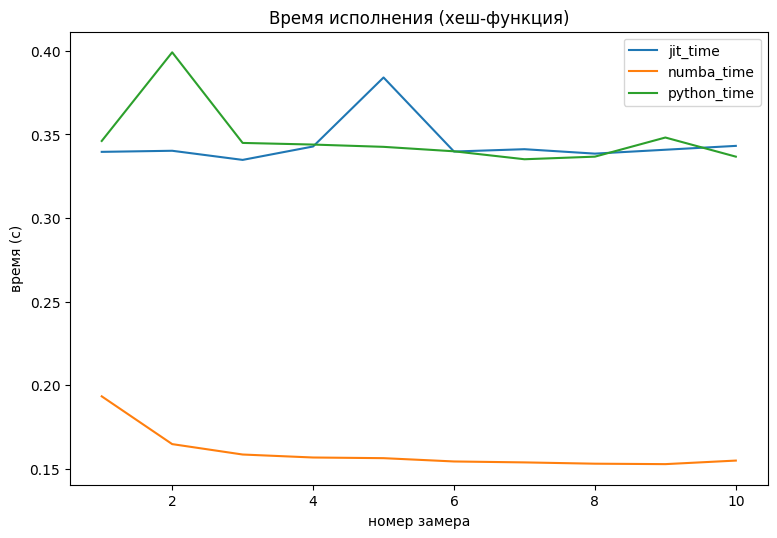

In [87]:
xs = range(1, 11)
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(xs, jit_exec_time, label='jit_time')
plt.plot(xs, numba_exec_time, label='numba_time')
plt.plot(xs, python_exec_time, label='python_time')
plt.xlabel('номер замера')
plt.ylabel('время (с)')
plt.title('Время исполнения (хеш-функция)')
plt.legend()
plt.savefig("report/plots/exec_hash.png")
plt.show()

Выводы:
* То что функция @jit работает примерно с такой же скоростью, как и питон, не вызывает вопросов
* Но откуда у numba оптимизация на битовых операциях (?)

### Числа Фибоначчи

In [47]:
def py_fib(n: int) -> int:
    if n < 2:
        return 1
    return py_fib(n - 1) + py_fib(n - 2)

@jit
def jit_fib(n: int) -> int:
    if n < 2:
        return 1
    return jit_fib(n - 1) + jit_fib(n - 2)

@numba.jit(nopython=True)
def numba_fib(n: int) -> int:
    if n < 2:
        return 1
    return numba_fib(n - 1) + numba_fib(n - 2)

In [72]:
arg = 30
print(f"fib({arg}) = {jit_fib(arg)}")
args = range(1, 31)
jit_fib_time, numba_fib_time, python_fib_time = [], [], []
for arg in args:
    jit_fib_time.append(timeit(lambda: jit_fib(arg), number=10))
    numba_fib_time.append(timeit(lambda: numba_fib(arg), number=10))
    python_fib_time.append(timeit(lambda: py_fib(arg), number=10))
print(jit_fib_time)
print(numba_fib_time)
print(python_fib_time)

fib(30) = 1346269
[8.200004231184721e-06, 7.499998901039362e-06, 7.100024959072471e-06, 7.199996616691351e-06, 0.00012260000221431255, 1.0399991879239678e-05, 7.199996616691351e-06, 7.399998139590025e-06, 8.800008799880743e-06, 8.200004231184721e-06, 8.700008038431406e-06, 9.800016414374113e-06, 1.1299998732283711e-05, 1.4100020052865148e-05, 1.6799982404336333e-05, 0.0001503999810665846, 3.370002377778292e-05, 5.880001117475331e-05, 8.140000863932073e-05, 0.00015590002294629812, 0.00021990001550875604, 0.000391999987186864, 0.0005577999982051551, 0.000978299998678267, 0.001493599993409589, 0.0024541000020690262, 0.003677200002130121, 0.006163699988974258, 0.009201200009556487, 0.015723899996373802]
[6.200018106028438e-06, 2.300017513334751e-06, 2.300017513334751e-06, 2.9999937396496534e-06, 3.00002284348011e-06, 2.9999937396496534e-06, 5.0000089686363935e-06, 4.3000036384910345e-06, 5.1000097300857306e-06, 6.400019628927112e-06, 9.300012607127428e-06, 1.3100012438371778e-05, 1.9900006

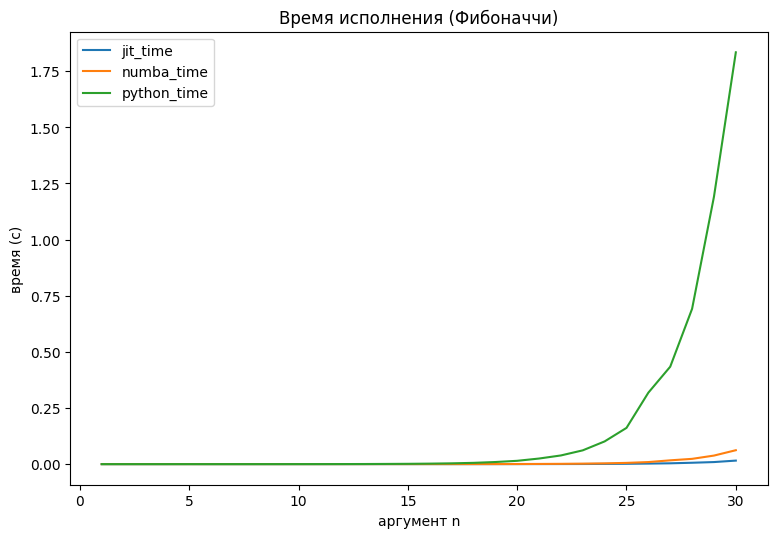

In [73]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_fib_time, label='jit_time')
plt.plot(args, numba_fib_time, label='numba_time')
plt.plot(args, python_fib_time, label='python_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (Фибоначчи)')
plt.legend()
plt.savefig("report/plots/exec_fib_3.png")
plt.show()

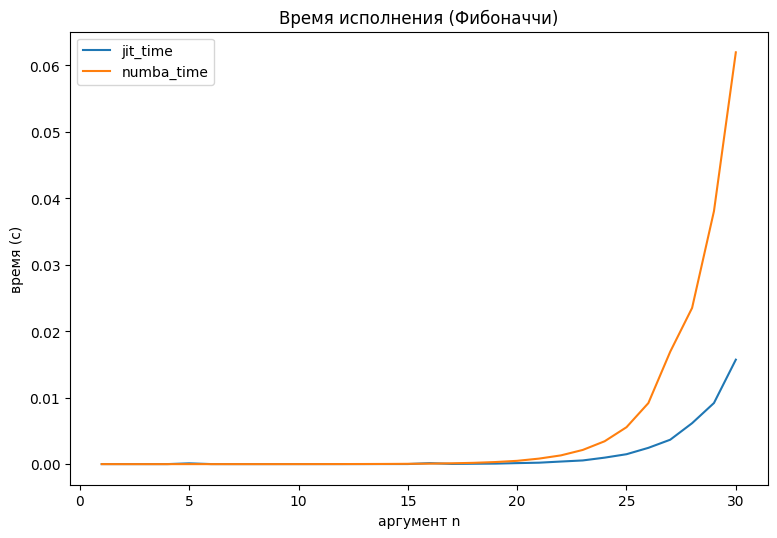

In [74]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_fib_time, label='jit_time')
plt.plot(args, numba_fib_time, label='numba_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (Фибоначчи)')
plt.legend()
plt.savefig("report/plots/exec_fib_2.png")
plt.show()

Выводы:
* На задачах рекурсии реализованный алгоритм показывается себя не так уж и плохо
(до 4-кратного ускорения на данном примере)

### Функция факториала

In [51]:
def py_fact(n: int) -> int:
    if n < 2:
        return 1
    return n * py_fact(n - 1)

@jit
def jit_fact(n: int) -> int:
    if n < 2:
        return 1
    return n * jit_fact(n - 1)

@numba.jit
def numba_fact(n: int) -> int:
    if n < 2:
        return 1
    return n * numba_fact(n - 1)

In [78]:
arg = 10
print(f"fib({arg}) = {jit_fact(arg)}")
args = range(1, 40)
jit_fact_time, numba_fact_time, python_fact_time = [], [], []
for arg in args:
    jit_fact_time.append(timeit(lambda: jit_fact(arg), number=10))
    numba_fact_time.append(timeit(lambda: numba_fact(arg), number=10))
    python_fact_time.append(timeit(lambda: py_fact(arg), number=10))
print(jit_fact_time)
print(numba_fact_time)
print(python_fact_time)

fib(10) = 3628800
[1.7099984688684344e-05, 7.90000194683671e-06, 6.699992809444666e-06, 6.799993570894003e-06, 6.699992809444666e-06, 7.199996616691351e-06, 6.999995093792677e-06, 7.099995855242014e-06, 6.700021913275123e-06, 6.89999433234334e-06, 6.699992809444666e-06, 6.799993570894003e-06, 6.999995093792677e-06, 6.89999433234334e-06, 6.799993570894003e-06, 7.099995855242014e-06, 6.89999433234334e-06, 7.399998139590025e-06, 6.999995093792677e-06, 7.199996616691351e-06, 8.000002708286047e-06, 1.3199984095990658e-05, 8.200004231184721e-06, 7.299997378140688e-06, 7.399998139590025e-06, 7.299997378140688e-06, 8.299975888803601e-06, 7.299997378140688e-06, 7.099995855242014e-06, 6.999995093792677e-06, 9.799987310543656e-06, 7.199996616691351e-06, 1.0000017937272787e-05, 9.599985787644982e-06, 7.489998824894428e-05, 1.0399991879239678e-05, 1.0099989594891667e-05, 9.299983503296971e-06, 0.00019069999689236283]
[8.299975888803601e-06, 2.2999884095042944e-06, 2.0999868866056204e-06, 2.39998917

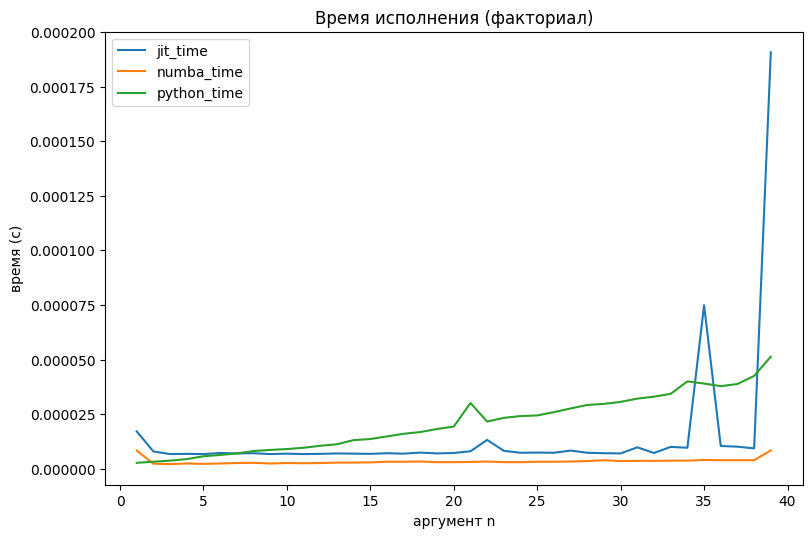

In [79]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_fact_time, label='jit_time')
plt.plot(args, numba_fact_time, label='numba_time')
plt.plot(args, python_fact_time, label='python_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (факториал)')
plt.legend()
plt.savefig("report/plots/exec_fact_3.png")
plt.show()

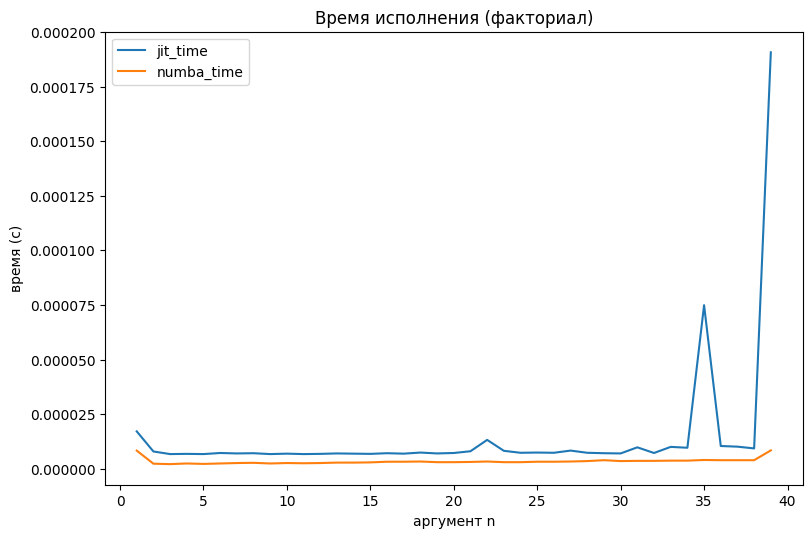

In [80]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_fact_time, label='jit_time')
plt.plot(args, numba_fact_time, label='numba_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (факториал)')
plt.legend()
plt.savefig("report/plots/exec_fact_3.png")
plt.show()

### Функция поиска n-го простого числа (наивная реализация)

In [58]:
def py_n_primary(n: int) -> int:
    count: int = 0
    number: int = 2
    while count < n:
        i: int = 2
        is_prime: bool = True
        while i < number:
            if number % i == 0:
                is_prime = False
                break
            i += 1
        if is_prime:
            count += 1
        number += 1
    return number - 1


jit_n_primary, numba_n_primary = get_jit_numba_realisations(py_n_primary)

In [82]:
arg = 1000
print(f"prim({arg}) = {jit_n_primary(arg)}")
args = range(10, 2010, 100)
jit_n_primary_time, numba_n_primary_time, python_n_primary_time = [], [], []
for arg in args:
    jit_n_primary_time.append(timeit(lambda: jit_n_primary(arg), number=1))
    numba_n_primary_time.append(timeit(lambda: numba_n_primary(arg), number=1))
    python_n_primary_time.append(timeit(lambda: py_n_primary(arg), number=1))
print(jit_n_primary_time)
print(numba_n_primary_time)
print(python_n_primary_time)

prim(1000) = 7919
[9.100011084228754e-06, 0.00020719997701235116, 0.0004391999973449856, 0.0010005999938584864, 0.0018428000039421022, 0.002985499973874539, 0.004382299986900762, 0.006068799993954599, 0.008072800002992153, 0.010272700019413605, 0.013287200010381639, 0.015859699982684106, 0.018952999991597608, 0.02258859999710694, 0.026284199993824586, 0.03030030001536943, 0.034987199993338436, 0.03977820000727661, 0.044524400000227615, 0.04992849999689497]
[5.80001506023109e-06, 0.0001112000027205795, 0.0004372999828774482, 0.0010204999998677522, 0.001847300009103492, 0.002974000002723187, 0.004363599990028888, 0.006058099999791011, 0.008223900018492714, 0.010242999996989965, 0.013160900009097531, 0.015671700006350875, 0.018854099995223805, 0.022339000017382205, 0.02593259999412112, 0.02990180000779219, 0.034939899982418865, 0.03953989999718033, 0.04424209997523576, 0.0490503000037279]
[9.300012607127428e-06, 0.001340099988738075, 0.005856200004927814, 0.014209400018444285, 0.028922400

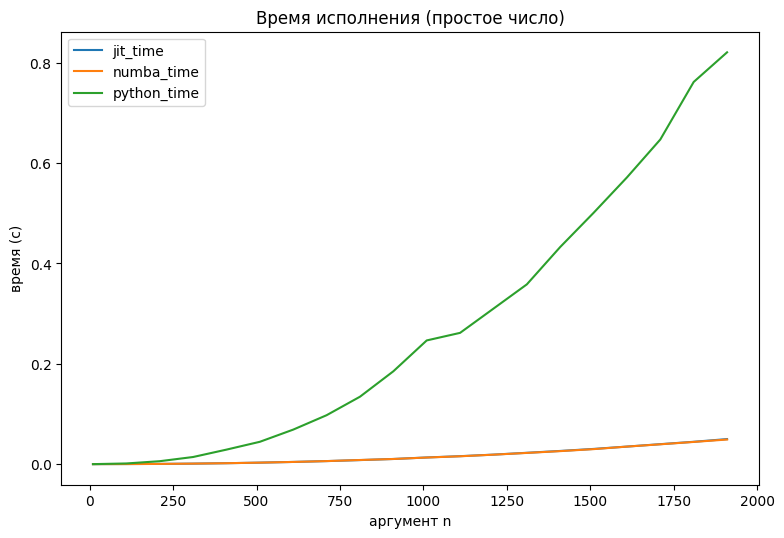

In [83]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_n_primary_time, label='jit_time')
plt.plot(args, numba_n_primary_time, label='numba_time')
plt.plot(args, python_n_primary_time, label='python_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (простое число)')
plt.legend()
plt.savefig("report/plots/exec_prim_3.png")
plt.show()

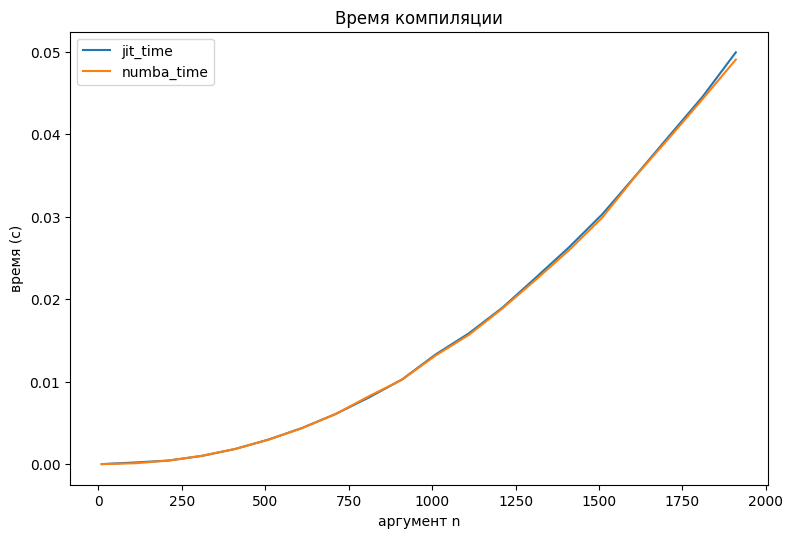

In [84]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_n_primary_time, label='jit_time')
plt.plot(args, numba_n_primary_time, label='numba_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время компиляции')
plt.legend()
plt.savefig("report/plots/exec_prim_2.png")
plt.show()

Выводы:
* Аналогичны выводам по экспоненте